** 1. Load Data **

In [78]:
# load raw data

from pandas import Series, DataFrame
import pandas as pd
stock = 'FB'
market = 'NASDAQ'
df = pd.read_csv("data/{}.csv".format(market), index_col='Date', 
                         parse_dates=True, usecols=['Date', 'Adj Close'], 
                         na_values =['nan'])
df = df.rename(columns={'Adj Close':market})
df_temp = pd.read_csv("data/{}.csv".format(stock), index_col='Date', 
                       parse_dates=True, usecols=['Date', 'Adj Close'], 
                       na_values =['nan'])
df_temp = df_temp.rename(columns={'Adj Close':stock})
df = df.join(df_temp)

print(df.shape)
df.head()

(504, 2)


,NASDAQ,FB
Date,,
2016-02-04,4509.560059,110.489998
2016-02-05,4363.140137,104.070000
2016-02-08,4283.750000,99.750000
2016-02-09,4268.759766,99.540001
2016-02-10,4283.589844,101.000000


** 2. Visualize Data **

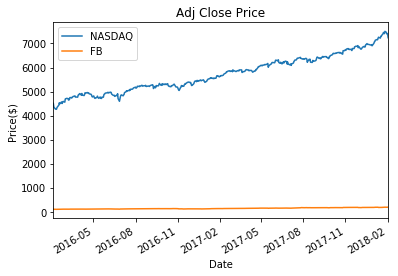

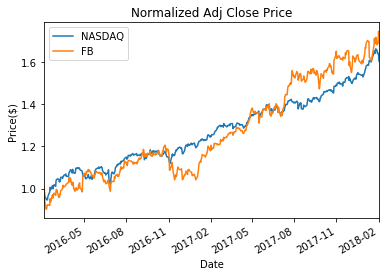

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

p1 = df.plot(title="Adj Close Price")
p1.set_xlabel("Date")
p1.set_ylabel("Price($)")
plt.show()

df_norm = df / df.iloc[0,:]
p2 = df_norm.plot(title="Normalized Adj Close Price")
p2.set_xlabel("Date")
p2.set_ylabel("Price($)")
plt.show()

** 3. Check for any missing data **

In [80]:
# check if there is any missing value
df.isnull().values.ravel().sum()

0

** 4. Create Features **

In [81]:
# create a function that binarize continuous variable 
def cat(a,t):
    b = pd.DataFrame.copy(a)
    b[b >= t] = 1
    b[b <  t] = 0
    return b

In [82]:
def get_rolling_mean(data, window):
    return data.rolling(window=window,center=False).mean()

def get_rolling_std(data, window):
    return data.rolling(window=window,center=False).std()

def get_bollinger_bands(data, window):
    rm = get_rolling_mean(data, window)
    rstd = get_rolling_std(data, window)
    upper_band = rm + 2 * rstd
    lower_band = rm - 2 * rstd
    return rm, upper_band, lower_band, rstd

rm, ub, lb, rstd = get_bollinger_bands(df_norm, 20)

# above bollinger band or below bollinger band
ab = df_norm-ub
ab_ind = cat(ab,0)

bb = df_norm-lb
bb_ind = cat(bb,0)

# deviation from rolling mean
drm = df_norm - rm

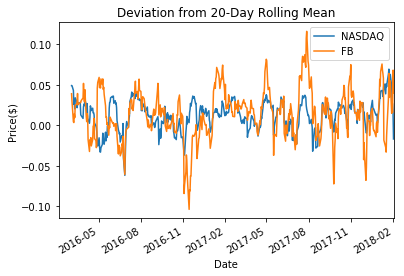

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

p3 = drm.plot(title="Deviation from 20-Day Rolling Mean")
p3.set_xlabel("Date")
p3.set_ylabel("Price($)")
plt.show()

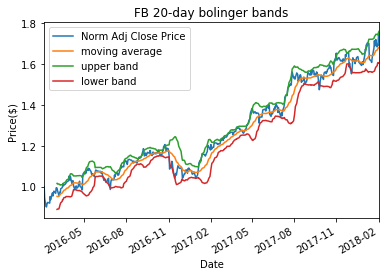

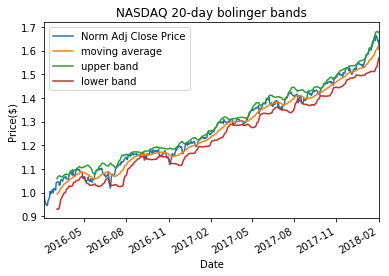

In [84]:
def plot_bollinger_bands(stock, window):
    p = df_norm[stock].plot(title=stock + ' ' + str(window) + '-day bolinger bands', 
                            label="Norm Adj Close Price")
    rm, ub, lb, rstd = get_bollinger_bands(df_norm[stock], window)
    rm.plot(label="moving average", ax = p)
    ub.plot(label="upper band", ax = p)
    lb.plot(label="lower band", ax = p)
    p.set_ylabel("Price($)")
    p.legend(loc='upper left')
    plt.show()

plot_bollinger_bands(stock, 20)
plot_bollinger_bands(market, 20)

In [85]:
# calculate daily return

def get_daily_return(data):
    daily_return = data / data.shift(1) - 1
    daily_return.iloc[0,:] = 0
    return daily_return
dr = get_daily_return(df_norm)
dr_ind = cat(dr,0)
dr.head()

,NASDAQ,FB
Date,,
2016-02-04,0.000000,0.000000
2016-02-05,-0.032469,-0.058105
2016-02-08,-0.018196,-0.041511
2016-02-09,-0.003499,-0.002105
2016-02-10,0.003474,0.014667


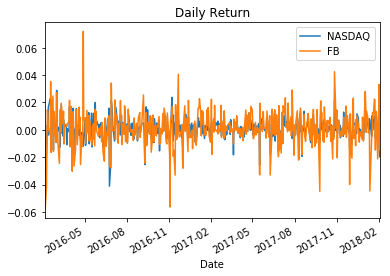

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

p3 = dr.plot(title="Daily Return")
p3.set_xlabel("Date")
plt.show()

In [88]:
# calculate sharp ratio

import numpy as np
def get_sharp_ratio(data, window):
    return np.sqrt(252) * get_rolling_mean(data, window) / get_rolling_std(data, window)
sr = get_sharp_ratio(df_norm, 60)
sr.tail()

,NASDAQ,FB
Date,,
2018-01-29,490.489969,693.355303
2018-01-30,482.815705,680.760704
2018-01-31,476.234520,669.987639
2018-02-01,470.535722,629.781853
2018-02-02,471.019054,609.819297


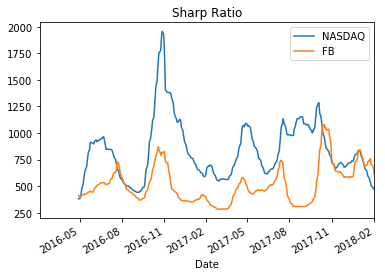

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

p3 = sr.plot(title="Sharp Ratio")
p3.set_xlabel("Date")
plt.show()

In [91]:
# calculate momentum

def get_momentum(data, window):
    momentum =  data / data.shift(window) - 1
    momentum.iloc[:window-1,:] = 0
    return momentum
mt = get_momentum(df_norm, 5)
mt.tail()

,NASDAQ,FB
Date,,
2018-01-29,0.007894,0.003291
2018-01-30,-0.007749,-0.011777
2018-01-31,-0.000483,0.001823
2018-02-01,-0.003414,0.029923
2018-02-02,-0.035282,0.001474


In [92]:
# momentum for the market

rm_mt = get_momentum(rm, 5)
rm_mt.tail()

,NASDAQ,FB
Date,,
2018-01-29,0.017604,0.014636
2018-01-30,0.017572,0.014248
2018-01-31,0.017164,0.013150
2018-02-01,0.016033,0.012271
2018-02-02,0.013177,0.010482


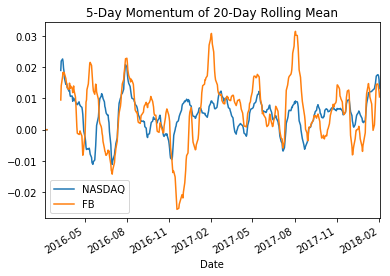

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

p3 = rm_mt.plot(title="5-Day Momentum of 20-Day Rolling Mean")
p3.set_xlabel("Date")
plt.show()

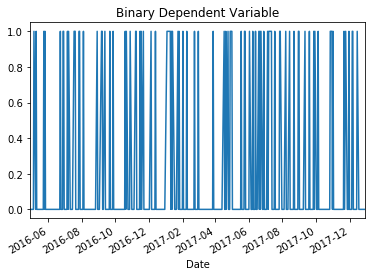

Number of days with 1+ percent increase: 87
Number of days in the data: 422


In [94]:
# visualize those days with 1%+ increase

y = cat(dr,0.01)
import matplotlib.pyplot as plt
%matplotlib inline

p3 = y[stock].loc['2016-04-29':'2017-12-29'].plot(title="Binary Dependent Variable")
p3.set_xlabel("Date")
plt.show()

print("Number of days with 1+ percent increase: %d" % y[stock].loc['2016-04-29':'2017-12-29'].sum())
print("Number of days in the data: %d" % len(y[stock].loc['2016-04-29':'2017-12-29']))

** 5. Prepare Data **

In [183]:
# prepare data for training and test data sets

def get_data(stock):
    data = pd.concat([df_norm[stock], drm[stock], ab[stock], bb[stock], 
                      sr[stock], dr[stock], rm_mt[stock], drm[market]], axis=1)
    data.columns = ['norm price','price - rm', 'price - ub', 'price - lb', 
                    'sharp ratio', 'daily return', 
                    'rm momentum', 'market - market_rm']
    return data
X = get_data(stock)

In [219]:
# randomly select 339 days for training data

X_train = X.loc['2016-04-29':'2017-08-31']
X_test  = X.loc['2017-09-01':'2017-12-29']
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

# continuous label
y_train = df_norm.loc['2016-05-02':'2017-09-01', stock]
y_test  = df_norm.loc['2017-09-05':'2018-01-02', stock]
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

# binarlize label
y_train2 = y_train / X_train['norm price'] - 1
y_test2  = y_test / X_test['norm price'] - 1

y_train2 = np.asarray(cat(y_train2,0.01))
y_test2 = np.asarray(cat(y_test2,0.01))

# the most recent known close price for the test data
g0 = X_test['norm price'][0]


In [220]:
# check the number of positive observations

#np.unique(y_train2, return_counts=True)
np.unique(y_test2, return_counts=True)

(array([ 0.,  1.]), array([68, 15], dtype=int64))

**** Descriptive Analysis ****

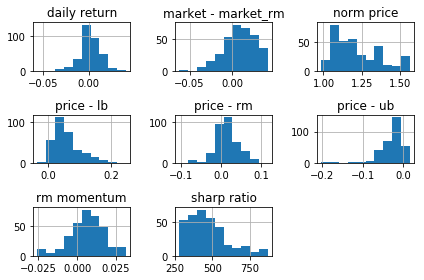

In [221]:
# histograms of feature variables and price

import matplotlib.pyplot as plt
%matplotlib inline
X_train.hist()
plt.tight_layout()

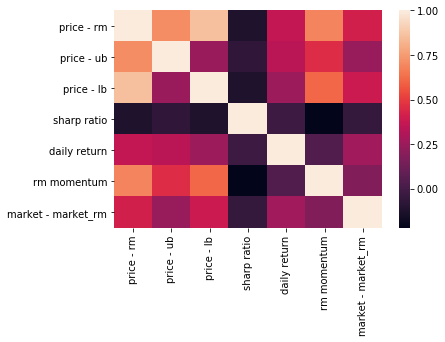

In [222]:
# visualize correlation matrix within feature variables

import seaborn as sns
%matplotlib inline

X_train = X_train.drop('norm price', axis=1)
X_test = X_test.drop('norm price', axis=1)

sns.heatmap(X_train.corr())

** Metrics - Net Gain **

In [223]:
# get net gain if make purchase decision based on the predicted closing price 
# at the begining of every day (buy at the beginning of day and sell at the end of day if predict 1; and not buy if predict 0)

def get_gain(y0,y_test,y_pred):
    gain = 0
    for i in range(len(y_test)):
        if i == 0:
            if y_pred[i] == 1:
                gain = y_test[i] - y0
        else:
            if y_pred[i] == 1:
                gain += y_test[i] - y_test[i-1]
    return gain

** Naive (Baseline) Prediction **

In [224]:
# predict all 1
y_pred_1 = np.asarray([1 for i in range(len(y_test))])
gain_pred_1 = get_gain(g0, y_test, y_pred_1)
print("Net gain if buy every day: %.4f" % gain_pred_1)
print("Validate answer: %.4f" % (y_test[82] - g0))

Net gain if buy every day: 0.0851
Validate answer: 0.0851


In [225]:
# predict all 0
y_pred_0 = np.asarray([0 for i in range(len(y_test))])
gain_pred_0 = get_gain(g0, y_test, y_pred_0)
print("Net gain if not buy any day: %.4f" % gain_pred_0)

Net gain if not buy any day: 0.0000


** Logistic Regression **

In [259]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, roc_auc_score
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train2)
y_pred = lr.predict(X_test)

results_lr = {}
results_lr['accuracy'] = accuracy_score(y_test2, y_pred)
results_lr['precision'] = precision_score(y_test2, y_pred)
results_lr['recall'] = recall_score(y_test2, y_pred)
results_lr['auc'] = roc_auc_score(y_test2, y_pred)
results_lr['gain'] = get_gain(g0, y_test, y_pred)
results_lr['best_param'] = "NA"


C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


** SVM **

In [240]:
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score, precision_score, recall_score, roc_auc_score

# parameters 
parameters = {'kernel':['rbf'], 'C':[1,5,10]}
clf = SVC(random_state = 0)

# scorers
scorers = {'accuracy': make_scorer(accuracy_score),
           'fbeta_score: 0.5': make_scorer(fbeta_score, beta=0.5),
           'fbeta_score: 2.0': make_scorer(fbeta_score, beta=2.0)}

results_svm = {}
for key, scorer in scorers.items():
    
    # Time series cross validation sets
    cv_sets = TimeSeriesSplit(n_splits = 10).split(X_train)
    
    results_svm[key] = {}
    
    grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=cv_sets)
    grid_fit = grid_obj.fit(X_train, y_train2)
    best_clf = grid_fit.best_estimator_
    y_pred = best_clf.predict(X_test)
    
    results_svm[key]['best_clf'] = best_clf
    results_svm[key]['accuracy'] = accuracy_score(y_test2, y_pred)
    results_svm[key]['precision'] = precision_score(y_test2, y_pred)
    results_svm[key]['recall'] = recall_score(y_test2, y_pred)
    results_svm[key]['auc'] = roc_auc_score(y_test2, y_pred)
    results_svm[key]['gain'] = get_gain(g0, y_test, y_pred)
    results_svm[key]['best_param'] = grid_fit.best_params_


C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

** XGBoost and GBM **

In [241]:
import xgboost
from sklearn import ensemble, cross_validation, model_selection
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, roc_auc_score

# classifiers
xgb = xgboost.XGBClassifier(random_state = 0)
gbm = ensemble.GradientBoostingClassifier(random_state = 0)

# parameters
parameters = {'learning_rate': [0.1, 0.2, 0.3], 
              'n_estimators': [200, 300, 500], 
              'max_depth': [2, 3, 4]}

# scorers
scorers = {'accuracy': make_scorer(accuracy_score),
           'fbeta_score: 0.5': make_scorer(fbeta_score, beta=0.5),
           'fbeta_score: 2.0': make_scorer(fbeta_score, beta=2.0)}

# model fit and select
results = {}
for clf in [xgb, gbm]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for key, scorer in scorers.items():
        
        # Time series cross validation sets
        cv_sets = TimeSeriesSplit(n_splits = 10).split(X_train)
        
        results[clf_name][key] = {}
        
        grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=cv_sets)
        grid_fit = grid_obj.fit(X_train, y_train2)
        best_clf = grid_fit.best_estimator_
        y_pred = best_clf.predict(X_test)
        
        results[clf_name][key]['best_clf'] = best_clf
        results[clf_name][key]['accuracy'] = accuracy_score(y_test2, y_pred)
        results[clf_name][key]['precision'] = precision_score(y_test2, y_pred)
        results[clf_name][key]['recall'] = recall_score(y_test2, y_pred)
        results[clf_name][key]['auc'] = roc_auc_score(y_test2, y_pred)
        results[clf_name][key]['gain'] = get_gain(g0, y_test, y_pred)
        results[clf_name][key]['best_param'] = grid_fit.best_params_
        

C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

In [242]:
# include benckmark model results in final results

results_benchmark = {}
for scorer in ['accuracy', 'fbeta_score: 0.5', 'fbeta_score: 2.0']:
    results_benchmark[scorer] = {}
    results_benchmark[scorer]['best_clf'] = None
    results_benchmark[scorer]['accuracy'] = y_test2.sum()/1.00/len(y_test2)
    results_benchmark[scorer]['precision'] = y_test2.sum()/1.00/len(y_test2)
    results_benchmark[scorer]['recall'] = 1.00
    results_benchmark[scorer]['auc'] = 0.50
    results_benchmark[scorer]['gain'] = gain_pred_1
    results_benchmark[scorer]['best_param'] = None
results['Benchmark'] = results_benchmark

# include SVM and Logistic Regression results
results['Logistic Regression'] = {'accuracy': results_lr,
                                  'fbeta_score: 0.5': results_lr,
                                  'fbeta_score: 2.0': results_lr}

results['SVM'] = results_svm

# rename classifier name
results['XGBoost'] = results.pop('XGBClassifier')
results['GBM'] = results.pop('GradientBoostingClassifier')



In [254]:
# print out results 

for key, clf in results.items():
    print(key)
    print("\n")
    for key, scorer in clf.items():
        print(key)
        print("Accuracy on test data: %.2f" % scorer['accuracy'])
        print("Precision on test data: %.2f" % scorer['precision'])
        print("Recall on test data: %.2f" % scorer['recall'])
        print("Area under ROC curve on test data: %.2f" % scorer['auc'])
        print("Net gain (normalized): %.2f" % scorer['gain'])
        print("Best parameters:")
        print(scorer['best_param'])
        print("\n")

Benchmark


accuracy
Accuracy on test data: 0.18
Precision on test data: 0.18
Recall on test data: 1.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.09
Best parameters:
None


fbeta_score: 0.5
Accuracy on test data: 0.18
Precision on test data: 0.18
Recall on test data: 1.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.09
Best parameters:
None


fbeta_score: 2.0
Accuracy on test data: 0.18
Precision on test data: 0.18
Recall on test data: 1.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.09
Best parameters:
None


Logistic Regression


accuracy
Accuracy on test data: 0.82
Precision on test data: 0.00
Recall on test data: 0.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.00
Best parameters:
NA


fbeta_score: 0.5
Accuracy on test data: 0.82
Precision on test data: 0.00
Recall on test data: 0.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.00
Best parameters:
NA


fbeta_score: 2.0
Accuracy 

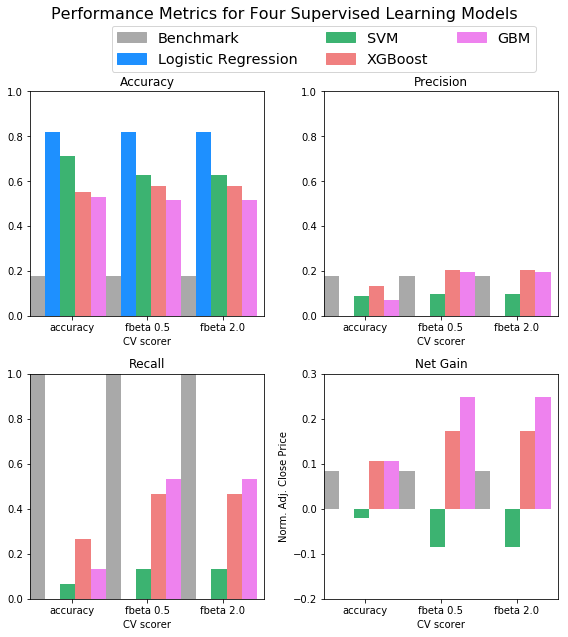

In [255]:
# the following visualization is developed based on the visuals.py from Udacity
# url: https://github.com/udacity/machine-learning/blob/master/projects/finding_donors/visuals.py

# visualize summary results

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

fig, ax = plt.subplots(2,2, figsize = (8,8))
bar_width = 0.2
colors = ['darkgrey', 'dodgerblue', 'mediumseagreen', 'lightcoral', 'violet']

for k, clf in enumerate(results.keys()):
        for j, metric in enumerate(['accuracy', 'precision', 'recall', 'gain']):
            for i, scorer in enumerate(['accuracy', 'fbeta_score: 0.5', 'fbeta_score: 2.0']):
                
                # Creative plot code
                ax[j//2, j%2].bar(i+k*bar_width, results[clf][scorer][metric], width = bar_width, color = colors[k])
                ax[j//2, j%2].set_xticks([0.45, 1.45, 2.45])
                ax[j//2, j%2].set_xticklabels(["accuracy", "fbeta 0.5", "fbeta 2.0"])
                ax[j//2, j%2].set_xlabel("CV scorer")
                ax[j//2, j%2].set_xlim((-0.1, 3.0))

# Add unique y-labels
ax[1, 1].set_ylabel("Norm. Adj. Close Price")

# Add titles
ax[0, 0].set_title("Accuracy")
ax[0, 1].set_title("Precision")
ax[1, 0].set_title("Recall")
ax[1, 1].set_title("Net Gain")
    
# Set y-limits for score panels
ax[0, 0].set_ylim((0, 1))
ax[0, 1].set_ylim((0, 1))
ax[1, 0].set_ylim((0, 1))
ax[1, 1].set_ylim((-0.2, 0.3))

# Create patches for the legend
patches = []
for i, clf in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = clf))
plt.legend(handles = patches, bbox_to_anchor = (0, 2.55), \
        loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
# Aesthetics
plt.suptitle("Performance Metrics for Four Supervised Learning Models", fontsize = 16, y = 1.10)
plt.tight_layout()
plt.show()


In [256]:
# store results based on the first test data

results_test1 = results.copy()

In [261]:
# create the second test data set 

X2_test  = X.loc['2017-09-29':'2018-02-01']
X2_test  = X2_test.reset_index(drop=True)

y2_test  = df_norm.loc['2017-10-02':'2018-02-02',stock]
y2_test  = y2_test.reset_index(drop=True)

y2_test2 = y2_test / X2_test['norm price'] - 1
y2_test2 = np.asarray(cat(y2_test2,0.01))

g2 = X2_test['norm price'][0]

X2_test = X2_test.drop('norm price', axis=1)

In [262]:
# create results folder to store results from the seond test data sets

y_pred = lr.predict(X2_test)

results2_lr = {}
results2_lr['accuracy'] = accuracy_score(y2_test2, y_pred)
results2_lr['precision'] = precision_score(y2_test2, y_pred)
results2_lr['recall'] = recall_score(y2_test2, y_pred)
results2_lr['auc'] = roc_auc_score(y2_test2, y_pred)
results2_lr['gain'] = get_gain(g2, y2_test, y_pred)
results2_lr['best_param'] = "NA"

results2_svm = results_svm.copy()
for key in results_svm.keys():
    print(key)
    y_pred = results2_svm[key]['best_clf'].predict(X2_test)
    results2_svm[key]['accuracy'] = accuracy_score(y2_test2, y_pred)
    results2_svm[key]['precision'] = precision_score(y2_test2, y_pred)
    results2_svm[key]['recall'] = recall_score(y2_test2, y_pred)
    results2_svm[key]['auc'] = roc_auc_score(y2_test2, y_pred)
    results2_svm[key]['gain'] = get_gain(g2, y2_test, y_pred)
    
results2 = results.copy()
for clf in results2.keys():
    if clf not in ['SVM' ,'Logistic Regression', 'Benchmark']:
        for key in results2[clf].keys():
            y_pred = results2[clf][key]['best_clf'].predict(X2_test)
            results2[clf][key]['accuracy'] = accuracy_score(y2_test2, y_pred)
            results2[clf][key]['precision'] = precision_score(y2_test2, y_pred)
            results2[clf][key]['recall'] = recall_score(y2_test2, y_pred)
            results2[clf][key]['auc'] = roc_auc_score(y2_test2, y_pred)
            results2[clf][key]['gain'] = get_gain(g2, y2_test, y_pred)

results2['Logistic Regression'] = {'accuracy': results2_lr,
                                   'fbeta_score: 0.5': results2_lr,
                                   'fbeta_score: 2.0': results2_lr}

results2['SVM'] = results2_svm

for key, clf in results2.items():
    print(key)
    print("\n")
    for key, scorer in clf.items():
        print(key)
        print("Accuracy on test data: %.2f" % scorer['accuracy'])
        print("Precision on test data: %.2f" % scorer['precision'])
        print("Recall on test data: %.2f" % scorer['recall'])
        print("Area under ROC curve on test data: %.2f" % scorer['auc'])
        print("Net gain (normalized): %.2f" % scorer['gain'])
        print("Best parameters:")
        print(scorer['best_param'])
        print("\n")

accuracy
fbeta_score: 0.5
fbeta_score: 2.0
Benchmark


accuracy
Accuracy on test data: 0.18
Precision on test data: 0.18
Recall on test data: 1.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.09
Best parameters:
None


fbeta_score: 0.5
Accuracy on test data: 0.18
Precision on test data: 0.18
Recall on test data: 1.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.09
Best parameters:
None


fbeta_score: 2.0
Accuracy on test data: 0.18
Precision on test data: 0.18
Recall on test data: 1.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.09
Best parameters:
None


Logistic Regression


accuracy
Accuracy on test data: 0.79
Precision on test data: 0.00
Recall on test data: 0.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.00
Best parameters:
NA


fbeta_score: 0.5
Accuracy on test data: 0.79
Precision on test data: 0.00
Recall on test data: 0.00
Area under ROC curve on test data: 0.50
Net gain (normalized): 0.00
Best 

C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [263]:
# get the number of positive observations in the second test data

np.unique(y2_test2, return_counts=True)

(array([ 0.,  1.]), array([68, 18], dtype=int64))

In [264]:
# get the net gain under naive all positive prediction in the second test data

y2_pred_1 = np.asarray([1 for i in range(len(y2_test))])
gain2_pred_1 = get_gain(g2, y2_test, y2_pred_1)
print("Net gain if buy every day: %.4f" % gain2_pred_1)
print("Validate answer: %.4f" % (y2_test[85] - g2))

Net gain if buy every day: 0.1757
Validate answer: 0.1757
